In [114]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hb20007/gender-classification")

print("Path to dataset files:", path)

Path to dataset files: /Users/jeongho/.cache/kagglehub/datasets/hb20007/gender-classification/versions/1


In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

import tensorflow as tf

import os

In [116]:
df = pd.read_csv(os.path.join(path, "Transformed Data Set - Sheet1.csv"))

In [117]:
df

,Favorite Color,Favorite Music Genre,Favorite Beverage,Favorite Soft Drink,Gender
0,Cool,Rock,Vodka,7UP/Sprite,F
1,Neutral,Hip hop,Vodka,Coca Cola/Pepsi,F
2,Warm,Rock,Wine,Coca Cola/Pepsi,F
3,Warm,Folk/Traditional,Whiskey,Fanta,F
4,Cool,Rock,Vodka,Coca Cola/Pepsi,F
...,...,...,...,...,...
61,Cool,Rock,Vodka,Coca Cola/Pepsi,M
62,Cool,Hip hop,Beer,Coca Cola/Pepsi,M
63,Neutral,Hip hop,Doesn't drink,Fanta,M
64,Cool,Rock,Wine,Coca Cola/Pepsi,M


In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Favorite Color        66 non-null     object
 1   Favorite Music Genre  66 non-null     object
 2   Favorite Beverage     66 non-null     object
 3   Favorite Soft Drink   66 non-null     object
 4   Gender                66 non-null     object
dtypes: object(5)
memory usage: 2.7+ KB


In [119]:
df.isna().sum()

Favorite Color          0
Favorite Music Genre    0
Favorite Beverage       0
Favorite Soft Drink     0
Gender                  0
dtype: int64

In [120]:
color_ordering = list(df["Favorite Color"].unique())

In [121]:
{column: list(df[column].unique()) for column in df.columns}

{'Favorite Color': ['Cool', 'Neutral', 'Warm'],
 'Favorite Music Genre': ['Rock',
  'Hip hop',
  'Folk/Traditional',
  'Jazz/Blues',
  'Pop',
  'Electronic',
  'R&B and soul'],
 'Favorite Beverage': ['Vodka',
  'Wine',
  'Whiskey',
  "Doesn't drink",
  'Beer',
  'Other'],
 'Favorite Soft Drink': ['7UP/Sprite', 'Coca Cola/Pepsi', 'Fanta', 'Other'],
 'Gender': ['F', 'M']}

In [122]:
def add_prefixes(df, column, prefix):
    return df[column].apply(lambda x: prefix + x)

In [123]:
df["Favorite Soft Drink"] = add_prefixes(df, "Favorite Soft Drink", "s_")
df["Favorite Beverage"] = add_prefixes(df, "Favorite Beverage", "b_")

In [124]:
pd.get_dummies(df["Favorite Color"], dtype=int)

,Cool,Neutral,Warm
0,1,0,0
1,0,1,0
2,0,0,1
3,0,0,1
4,1,0,0
...,...,...,...
61,1,0,0
62,1,0,0
63,0,1,0
64,1,0,0


In [125]:
def onehot_encode(df, columns):
    for column in columns:
        dummies = pd.get_dummies(df[column], dtype=int)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop([column], axis=1)
    return df

In [126]:
df = onehot_encode(
    df, ["Favorite Music Genre", "Favorite Beverage", "Favorite Soft Drink"]
)

In [127]:
df["Favorite Color"] = df["Favorite Color"].apply(lambda x: color_ordering.index(x))

In [128]:
df["Favorite Color"].unique()

array([0, 1, 2])

In [129]:
label_encoder = LabelEncoder()
df["Gender"] = label_encoder.fit_transform(df["Gender"])
gender_mappings = {index: value for index, value in enumerate(label_encoder.classes_)}

In [130]:
gender_mappings

{0: 'F', 1: 'M'}

In [131]:
df

,Favorite Color,Gender,Electronic,Folk/Traditional,Hip hop,Jazz/Blues,Pop,R&B and soul,Rock,b_Beer,b_Doesn't drink,b_Other,b_Vodka,b_Whiskey,b_Wine,s_7UP/Sprite,s_Coca Cola/Pepsi,s_Fanta,s_Other
0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0
1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,2,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
3,2,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0
62,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
63,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
64,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0


In [132]:
y = df["Gender"]
X = df.drop(["Gender"], axis=1)

In [133]:
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [134]:
X

,Favorite Color,Electronic,Folk/Traditional,Hip hop,Jazz/Blues,Pop,R&B and soul,Rock,b_Beer,b_Doesn't drink,b_Other,b_Vodka,b_Whiskey,b_Wine,s_7UP/Sprite,s_Coca Cola/Pepsi,s_Fanta,s_Other
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
62,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
63,0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

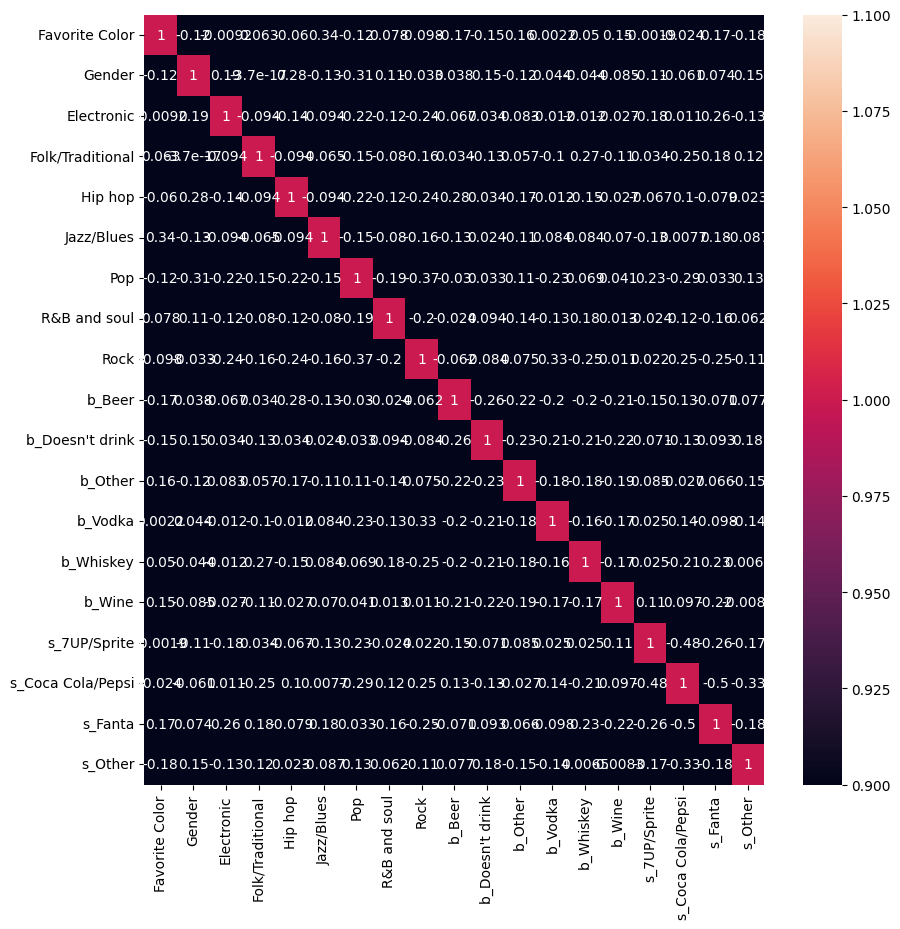

In [141]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, vmin=1, vmax=1)
plt.show()

In [150]:
inputs = tf.keras.Input(shape=(18,))
x = tf.keras.layers.Dense(64, activation="relu")(inputs)
x = tf.keras.layers.Dense(64, activation="relu")(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],  # no skew so it's fine
)

batch_size = 32
epochs = 22

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    verbose=0,
)

In [164]:
# 1. Add regularization and dropout to prevent overfitting
inputs = tf.keras.Input(shape=(18,))
x = tf.keras.layers.Dense(
    128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)
)(inputs)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(
    64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)
)(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# 2. Modify compilation with learning rate and better metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC()],
)

# 3. Add callbacks for better training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3),
]

# 4. Adjust training parameters
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=16,  # Smaller batch size
    epochs=29,  # More epochs (EarlyStopping will prevent overfitting)
    callbacks=callbacks,
    verbose=0,
)

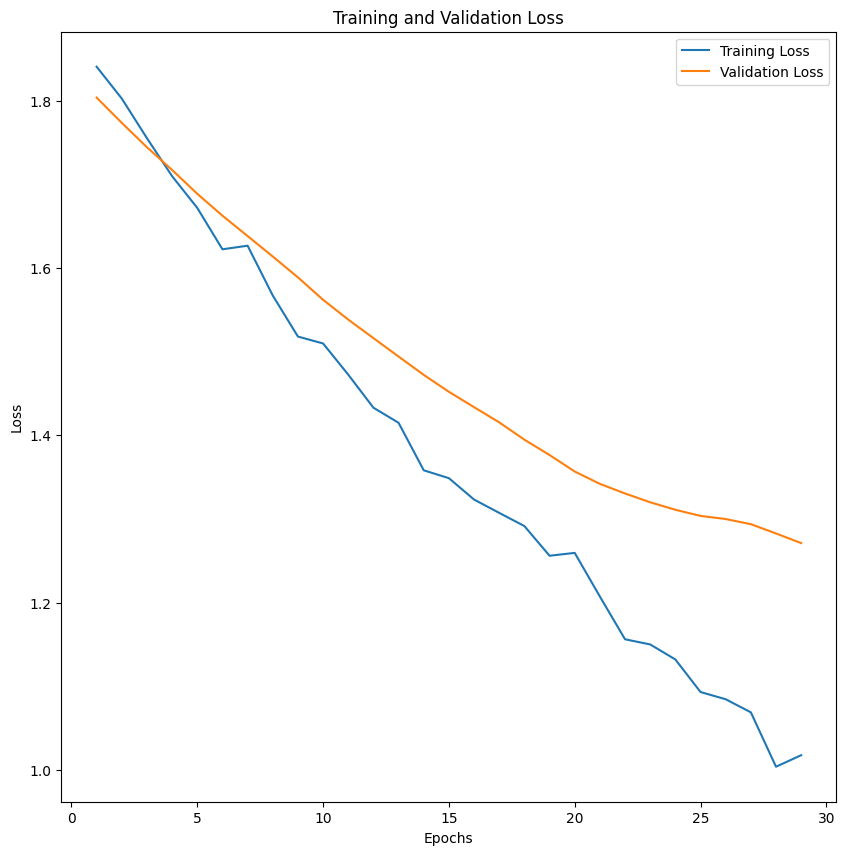

In [165]:
# plt.figure(figsize=(10,10))
# epochs_range = range(1, epochs+1)
# train_loss = history.history['loss']
# val_loss = history.history['val_loss']

# plt.plot(epochs_range, train_loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')

# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.show()

plt.figure(figsize=(10, 10))
# Use the actual number of epochs from the history
epochs_range = range(1, len(history.history["loss"]) + 1)
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.plot(epochs_range, train_loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")

plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [166]:
np.argmin(val_loss)

28

In [167]:
model.evaluate(X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3500 - auc_2: 0.3242 - loss: 1.4164


[1.416383981704712, 0.3499999940395355, 0.32417580485343933]